## Prediction of default in banking products - Credit Cards

Any financial crunch in an oraganization or customers personal profile is over a period of time. There are indicators which can be used to anticipate the final outcome, such as late payments, calls to the customer services, enquiries about the products, a different browsing pattern on the web or mobile app. By using such patterns it is possible to prevent, or at least guide the process and provide a better service for the customer as well as reduced risks for the bank.

The goal of this projet is to predict credit cards defaulting with the help of statistics, machine learning and deep learning.


#### This notebook unfolds in the following phases :

1. Getting the Data
2. Data Preparation
3. Data exploration and Descriptive analytics
4. Feature Engineering and ETL
* Dimensionality Reduction
* Model definition and training
* Model deployment and evaluation

In [1]:
#Importing the required python libraries

import urllib
import re # regex
import pytz as tz #time
from datetime import datetime #time
import numpy as np #data explore
np.random.seed(1337)
import xlrd #support for reading excel files
import pandas as pd # dataframes in python


## 1. Getting the Data

* Data is imported in CSV format from a local library
* We use pandas to read the data from its original excel format into a dataframe


In [2]:
# The code was removed by Watson Studio for sharing.

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


## 2. Data Preparation

* Renaming the Col Pay_0 to Pay_1
* Transforming the upper case col Names to lower case
* Eliminating the Index column

In [3]:
df.columns = [x.lower() for x in df.columns]
df = df.rename(index=str, columns={"pay_0": "pay_1"})
df = df.drop('id', axis=1)
df.columns

Index(['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_1', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
       'default.payment.next.month'],
      dtype='object')

In [4]:
#Checking for any NULL values in dataset

df.isnull().sum()

limit_bal                     0
sex                           0
education                     0
marriage                      0
age                           0
pay_1                         0
pay_2                         0
pay_3                         0
pay_4                         0
pay_5                         0
pay_6                         0
bill_amt1                     0
bill_amt2                     0
bill_amt3                     0
bill_amt4                     0
bill_amt5                     0
bill_amt6                     0
pay_amt1                      0
pay_amt2                      0
pay_amt3                      0
pay_amt4                      0
pay_amt5                      0
pay_amt6                      0
default.payment.next.month    0
dtype: int64

### Attributes description

This study uses 30,000 records across 23 variables as explanatory variables, extracted/interpreted from :

   1. limit_bal           = Amount of the given credit
 
 
   2. sex                  = Gender (1 = male; 2 = female)


   3. education            = Education (1 = graduate school; 2 = university; 3 = high school; 4 = others)


   4. marriage             = Marital status (1 = married; 2 = single; 3 = others)


   5. age                  = Age (years)


   6. to 11. : pay_1 - pay_6        = History of past payment. 


   12. to 17. : bill_amt1-bill_amt5  = Amount of bill statement. 


   18. to 23. : pay_amt1-pay_amt6    = Amount of previous payment


   ----------------------------------------------------------------------------------------

In [5]:
# To know the categories present in the categorical features.

list_of_cols = ['sex', 'education', 'marriage', 'age', 'pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
for col in list_of_cols:
    print(str(col) + ": "+ str(df[col].unique()))

sex: [2 1]
education: [2 1 3 5 4 6 0]
marriage: [1 2 3 0]
age: [24 26 34 37 57 29 23 28 35 51 41 30 49 39 40 27 47 33 32 54 58 22 25 31
 46 42 43 45 56 44 53 38 63 36 52 48 55 60 50 75 61 73 59 21 67 66 62 70
 72 64 65 71 69 68 79 74]
pay_1: [ 2 -1  0 -2  1  3  4  8  7  5  6]
pay_2: [ 2  0 -1 -2  3  5  7  4  1  6  8]
pay_3: [-1  0  2 -2  3  4  6  7  1  5  8]
pay_4: [-1  0 -2  2  3  4  5  7  6  1  8]
pay_5: [-2  0 -1  2  3  5  4  7  8  6]
pay_6: [-2  2  0 -1  3  6  4  7  8  5]


In [6]:
# EDUCATION column has following categores: 
#1 means  Graduate school,
#2 means  University, 
#3 means  High school, 
#4 means  Others, 
#0,5,6 is  Unknown, 

# Since 0,5,6 categories are the unknowns. Hence, replacing those with 'Others category' i.e. category 4.

fil = (df.education == 5) | (df.education == 6) | (df.education == 0)
df.loc[fil, 'education'] = 4
df.education.value_counts()

2    14030
1    10585
3     4917
4      468
Name: education, dtype: int64

In [7]:
#Create a target Column

df['target'] = df['default.payment.next.month'].astype('category')
print("Target variable:       '{}' -> '{}'".format('default payment next month', 'target'))

Target variable:       'default payment next month' -> 'target'


## 3. Data exploration and Descriptive analytics

In [8]:
df.describe()

,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.842267,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.744494,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,1.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,4.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


After cleaning the data.
The average credit card limit is 167,484 . The maximum limit is 1,000,000. Hence, the standard deviation is high at 129748.
The average age of the credit card clients is around 35.

**Analysing past payment delays**

In [9]:
pattern = re.compile("^pay_[0-9]+$")
pay_status_columns = [ x for x in df.columns if (pattern.match(x))]

df[pay_status_columns].head(10)

,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6
0,2,2,-1,-1,-2,-2
1,-1,2,0,0,0,2
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,-1,0,-1,0,0,0
5,0,0,0,0,0,0
6,0,0,0,0,0,0
7,0,-1,-1,0,0,-1
8,0,0,2,0,0,0
9,-2,-2,-2,-2,-1,-1


Plotting the payments delays on a barplot

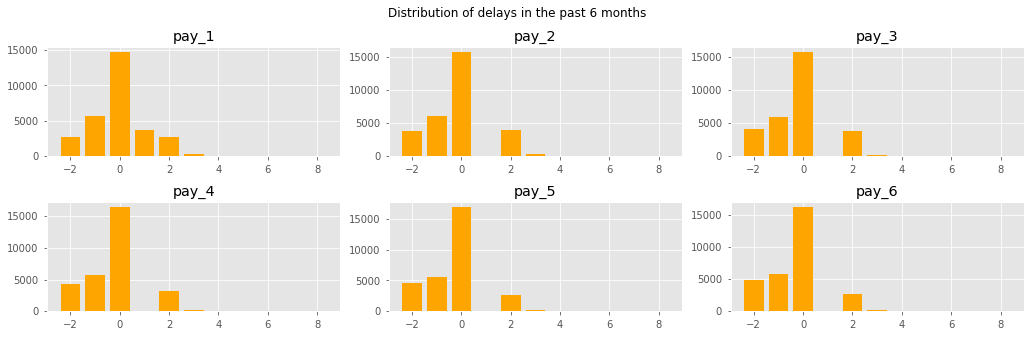

In [66]:
%matplotlib inline
import matplotlib.pyplot as plt

#defaults
plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.rcParams.update({'font.size': 10})
plt.rcParams['xtick.major.pad']='5'
plt.rcParams['ytick.major.pad']='5'

plt.style.use('ggplot')

# pay status columns
pattern = re.compile("^pay_[0-9]+$")
pay_status_columns = [ x for x in df.columns if (pattern.match(x))]

fig, ax = plt.subplots(2,3)
fig.set_size_inches(15,5)
fig.suptitle('Distribution of delays in the past 6 months')

for i in range(len(pay_status_columns)):
    row,col = int(i/3), i%3

    d  = df[pay_status_columns[i]].value_counts()
    ax[row,col].bar(d.index, d, align='center', color='orange')
    ax[row,col].set_title(pay_status_columns[i])

plt.tight_layout(pad=3.0, w_pad=0.5, h_pad=1.0)
plt.show()

It can be observed that most of the perolple pay well on time and some people also pay 2 months in advance. The negative plot represents the delayed payments which can be an indicator of financial health crisis. Since the attribute description may not include such details, it is always a good idea to explore the data before computations

### Outstanding Credit

Credit accumulating over the months. A positive number denotes amount to be repaid

In [11]:
# bill columns
pattern = re.compile("^bill_amt[0-9]+$")
bill_columns = [ x for x in df.columns if (pattern.match(x))]
df[bill_columns].describe()

,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6
count,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000
mean,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400
std,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537
min,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000
25%,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000
50%,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000
75%,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000
max,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000


In [12]:
df[bill_columns].head(10)

,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6
0,3913.0,3102.0,689.0,0.0,0.0,0.0
1,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0
2,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0
3,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0
4,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0
5,64400.0,57069.0,57608.0,19394.0,19619.0,20024.0
6,367965.0,412023.0,445007.0,542653.0,483003.0,473944.0
7,11876.0,380.0,601.0,221.0,-159.0,567.0
8,11285.0,14096.0,12108.0,12211.0,11793.0,3719.0
9,0.0,0.0,0.0,0.0,13007.0,13912.0


### Payments in previous months

In [13]:
# pay status columns
pattern = re.compile("^pay_amt[0-9]+$")
pay_amount_columns = [ x for x in df.columns if (pattern.match(x))]
df[pay_amount_columns].describe()

,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6
count,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


In [14]:
df[pay_amount_columns].head(10)


,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6
0,0.0,689.0,0.0,0.0,0.0,0.0
1,0.0,1000.0,1000.0,1000.0,0.0,2000.0
2,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0
3,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0
4,2000.0,36681.0,10000.0,9000.0,689.0,679.0
5,2500.0,1815.0,657.0,1000.0,1000.0,800.0
6,55000.0,40000.0,38000.0,20239.0,13750.0,13770.0
7,380.0,601.0,0.0,581.0,1687.0,1542.0
8,3329.0,0.0,432.0,1000.0,1000.0,1000.0
9,0.0,0.0,0.0,13007.0,1122.0,0.0


In [15]:
df['limit_bal'].describe()

count      30000.000000
mean      167484.322667
std       129747.661567
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: limit_bal, dtype: float64

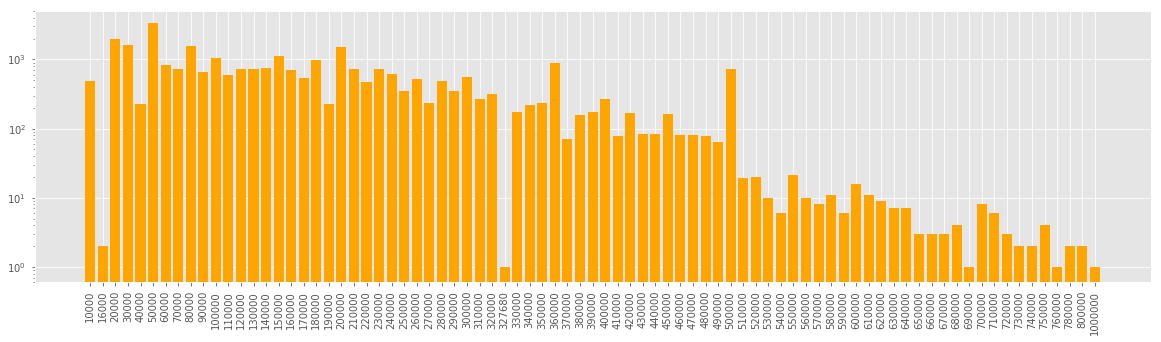

In [16]:

# limit balance
fig = plt.figure()
fig.set_size_inches(20,5)
ax = fig.add_subplot(111)

d = df.groupby(['limit_bal']).size()
ax.set_yscale("log")
ax.set_xticks(np.arange(len(d)))
ax.set_xticklabels(['%d' % i for i in d.index], rotation='vertical')
p = ax.bar(np.arange(len(d)), d, color='orange')

A decreasing graph over the higher credit balances indicates that most of the card holders are in the lower bracket of limits

## Exploring Credit default

The percentage of default is 22.12% out of 30000 observations


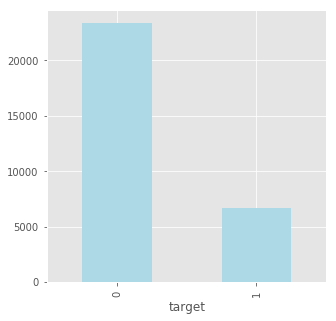

In [17]:
fig = plt.figure()
fig.set_size_inches(5,5)
d = df.groupby(['target']).size()
p = d.plot(kind='bar', color='lightblue')

print("The percentage of default is {}% out of {} observations".format(100* d[1]/(d[1]+d[0]), d[1]+d[0]))

In [18]:
df['sex'] = df['sex'].astype('category').cat.rename_categories(['M', 'F'])
df['marriage'] = df['marriage'].astype('category').cat.rename_categories(['married', 'single', 'other', 'na'])
df['age_cat'] = pd.cut(df['age'], range(0, 100, 10), right=False).astype(str)

In [19]:
pattern = re.compile("^pay_[0-9]+$")
pay_status_columns = [ x for x in df.columns if (pattern.match(x))]
for i in pay_status_columns:
    df[i] = df[i].astype('category')

### Analysing the defaulters data across different parameters

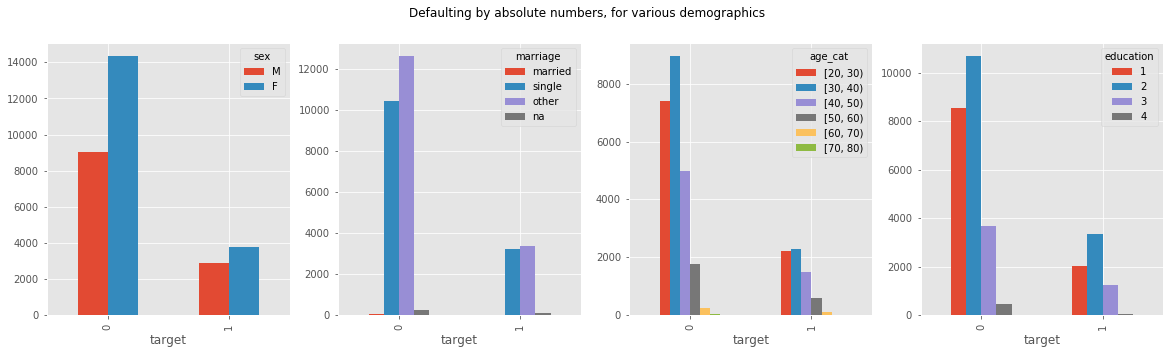

In [20]:
fig, ax = plt.subplots(1,4)
fig.set_size_inches(20,5)
fig.suptitle('Defaulting by absolute numbers, for various demographics')

d = df.groupby(['target', 'sex']).size()
p = d.unstack(level=1).plot(kind='bar', ax=ax[0])

d = df.groupby(['target', 'marriage']).size()
p = d.unstack(level=1).plot(kind='bar', ax=ax[1])

d = df.groupby(['target', 'age_cat']).size()
p = d.unstack(level=1).plot(kind='bar', ax=ax[2])

d = df.groupby(['target', 'education']).size()
p = d.unstack(level=1).plot(kind='bar', ax=ax[3])

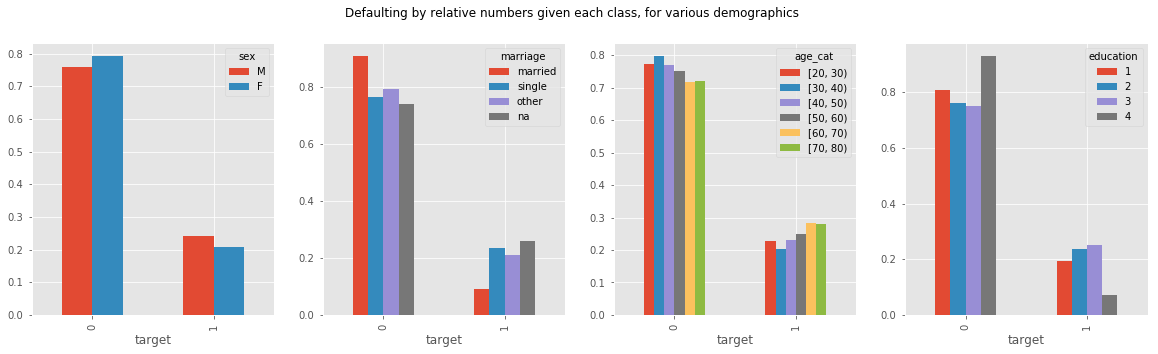

In [21]:
# Defaulters in absolute terms


fig, ax = plt.subplots(1,4)
fig.set_size_inches(20,5)
fig.suptitle('Defaulting by relative numbers given each class, for various demographics')

d = df.groupby(['target', 'sex']).size().unstack(level=1)
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[0])

d = df.groupby(['target', 'marriage']).size().unstack(level=1)
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[1])

d = df.groupby(['target', 'age_cat']).size().unstack(level=1)
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[2])

d = df.groupby(['target', 'education']).size().unstack(level=1)
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[3])

**We observe that higher default rates are among the higher age group single males with lower education background**

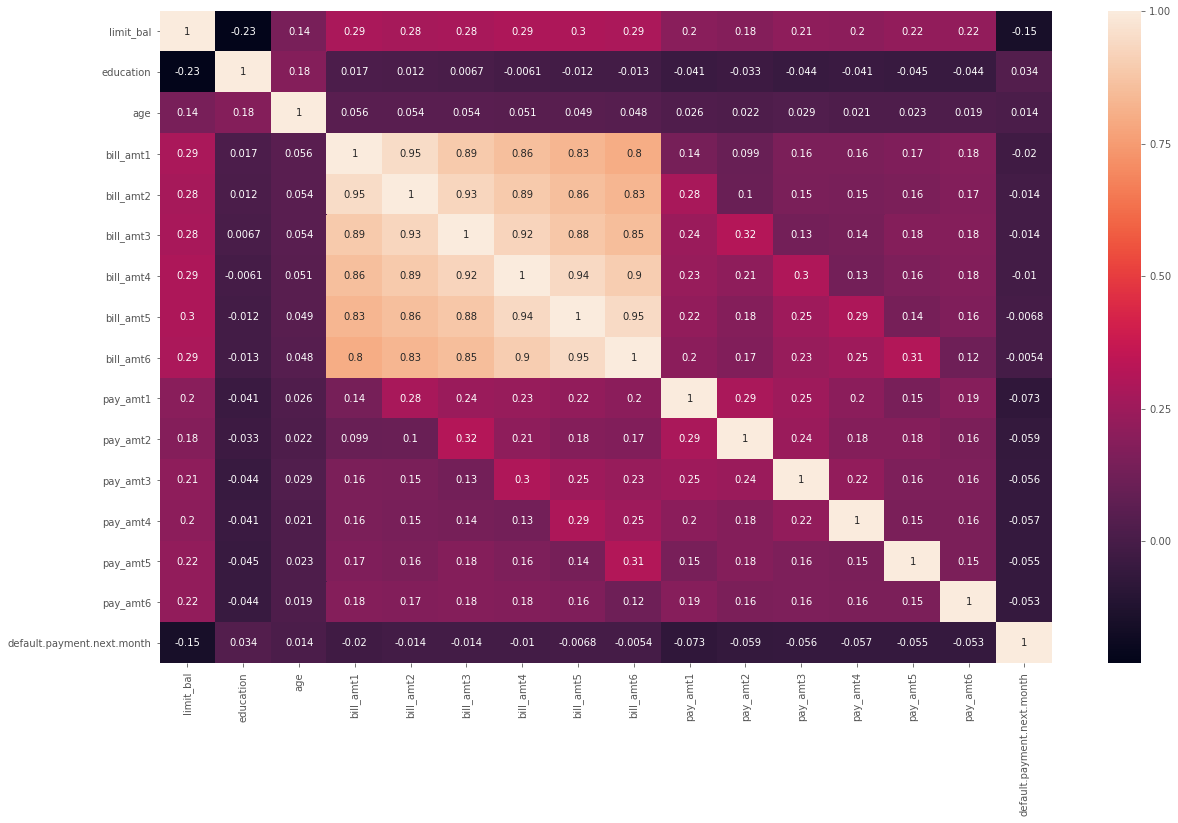

In [22]:
# Reviewing the inter corelation of variables with teh help of heat map.


import seaborn as sns

cor=df.corr()
plt.figure(figsize=(20,12))

# Heatmap
sns.heatmap(cor, annot=True)
plt.show()

Correlation of Y with independent variables: The Default Payment is positively correleated with Education, age and Negatively Correlated with LIMIT_BAL and PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY6, PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6.

In [23]:
# Converting Categories to float 

df['target']=df['target'].astype(float)
df['pay_1']=df['pay_1'].astype(float)
df['pay_2']=df['pay_2'].astype(float)
df['pay_3']=df['pay_3'].astype(float)
df['pay_4']=df['pay_4'].astype(float)
df['pay_5']=df['pay_5'].astype(float)
df['pay_6']=df['pay_6'].astype(float)

df['sex']=df['sex'].astype('category').cat.codes
df['marriage'] = df['marriage'].astype('category').cat.codes

df['age']=df['age'].astype(float)
df['sex'] = df['sex'].astype(float)
df['marriage'] = df['marriage'].astype(float)

X=df.drop(['target','age_cat'],axis=1)
y=df['target']

## 4. Feature Engineering and ETL

In [24]:
# Splitting the data into test and train data with 70% for training the model and 30% for testing

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(21000, 24)
(9000, 24)
(21000,)
(9000,)


### Feature Selection

In [25]:

import warnings
from sklearn.feature_selection import SelectKBest, f_classif

warnings.simplefilter(action='ignore', category=(UserWarning,RuntimeWarning))

selector = SelectKBest(f_classif, 24)
selector.fit(X, y)

SelectKBest(k=24, score_func=<function f_classif at 0x7f687ee588c8>)

In [26]:
top_indices = np.nan_to_num(selector.scores_).argsort()[-24:][::-1]
selector.scores_[top_indices]
X.columns[top_indices]

Index(['default.payment.next.month', 'pay_1', 'pay_2', 'pay_3', 'pay_4',
       'pay_5', 'pay_6', 'limit_bal', 'pay_amt1', 'pay_amt2', 'pay_amt4',
       'pay_amt3', 'pay_amt5', 'pay_amt6', 'sex', 'education', 'marriage',
       'bill_amt1', 'bill_amt2', 'bill_amt3', 'age', 'bill_amt4', 'bill_amt5',
       'bill_amt6'],
      dtype='object')

### Feature Scaling

In [27]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
scaler.fit(X)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [28]:
from sklearn.pipeline import Pipeline

preprocess = Pipeline([('anova', selector), ('scale', scaler)])
preprocess.fit(X,y)

X_prep = preprocess.transform(X)

### Visualization function to plot ROC curve and finding AUC

In [29]:
import itertools
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score, confusion_matrix

def plot_cm(ax, y_true, y_pred, classes, title, th=0.5, cmap=plt.cm.Blues):
    y_pred_labels = (y_pred>th).astype(int)
    
    cm = confusion_matrix(y_true, y_pred_labels)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

def plot_auc(ax, y_train, y_train_pred, y_test, y_test_pred, th=0.5):

    y_train_pred_labels = (y_train_pred>th).astype(int)
    y_test_pred_labels  = (y_test_pred>th).astype(int)

    fpr_train, tpr_train, _ = roc_curve(y_train,y_train_pred)
    roc_auc_train = auc(fpr_train, tpr_train)
    acc_train = accuracy_score(y_train, y_train_pred_labels)

    fpr_test, tpr_test, _ = roc_curve(y_test,y_test_pred)
    roc_auc_test = auc(fpr_test, tpr_test)
    acc_test = accuracy_score(y_test, y_test_pred_labels)

    ax.plot(fpr_train, tpr_train)
    ax.plot(fpr_test, tpr_test)

    ax.plot([0, 1], [0, 1], 'k--')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve')
    
    train_text = 'train acc = {:.3f}, auc = {:.2f}'.format(acc_train, roc_auc_train)
    test_text = 'test acc = {:.3f}, auc = {:.2f}'.format(acc_test, roc_auc_test)
    ax.legend([train_text, test_text])

## 6. Model definition and training

### 6.1) Logistic Regression

In [30]:

from sklearn import linear_model

# Create logistic regression object
regr = linear_model.LogisticRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

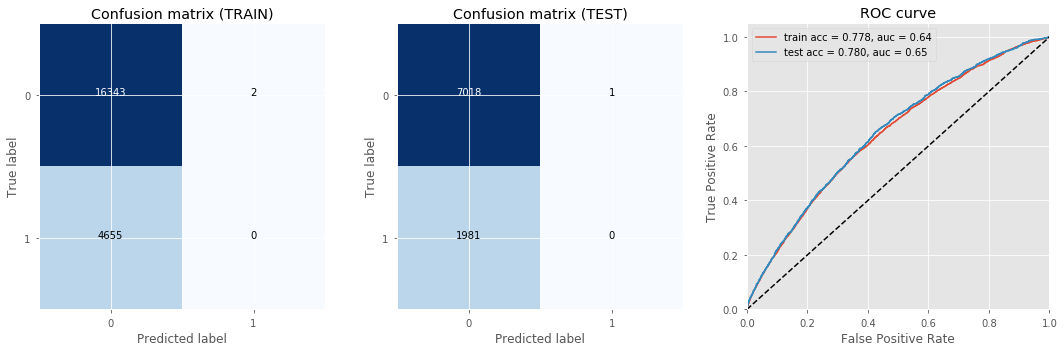

In [31]:
y_train_pred = regr.predict_proba(X_train)[:,1]
y_test_pred = regr.predict_proba(X_test)[:,1]

threshold = 0.5

fig,ax = plt.subplots(1,3)
fig.set_size_inches(15,5)

plot_cm(ax[0],  y_train, y_train_pred, [0,1], 'Confusion matrix (TRAIN)', threshold)
plot_cm(ax[1],  y_test, y_test_pred,   [0,1], 'Confusion matrix (TEST)', threshold)
plot_auc(ax[2], y_train, y_train_pred, y_test, y_test_pred, threshold)
    
plt.tight_layout()
plt.show()

### 6.2) Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=3000, min_samples_leaf=5, class_weight='balanced')
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=3000, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

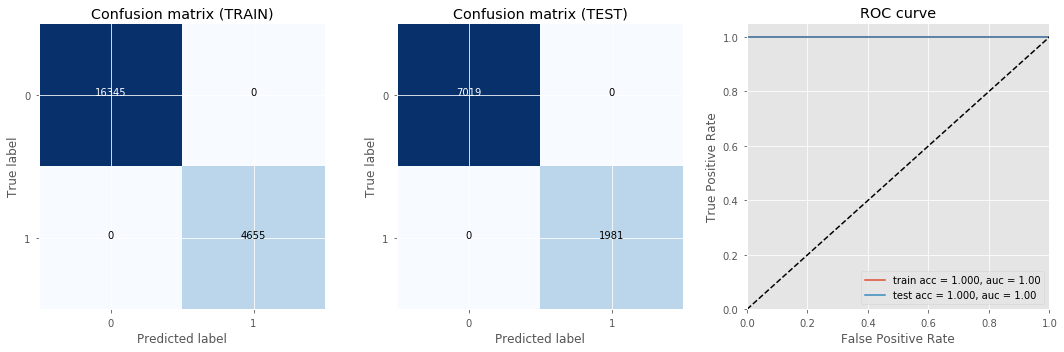

In [33]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score

threshold = 0.5
y_train_pred = rf.predict_proba(X_train)[:,1]
y_test_pred = rf.predict_proba(X_test)[:,1]

fig,ax = plt.subplots(1,3)
fig.set_size_inches(15,5)

plot_cm(ax[0],  y_train, y_train_pred, [0,1], 'Confusion matrix (TRAIN)', threshold)
plot_cm(ax[1],  y_test, y_test_pred,   [0,1], 'Confusion matrix (TEST)', threshold)
plot_auc(ax[2], y_train, y_train_pred, y_test, y_test_pred, threshold)
    
plt.tight_layout()
plt.show()

An accuracy of 1.0 reflects a perfect model, means the model pefectly predicts the outcomes from and testing data set provided.
The ROC AUC is 1.0 because the minimum of the positive class is higher than the maximum of the negative class

###  6.3) Decision Trees boosting

In [34]:
import xgboost as xgb

In [35]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [36]:
num_round = 5
evallist  = [(dtest,'eval'), (dtrain,'train')]
param = {'objective':'binary:logistic', 'silent':1, 'eval_metric': ['error', 'logloss']}

bst = xgb.train( param, dtrain, num_round, evallist )

[0]	eval-error:0	eval-logloss:0.437569	train-error:0	train-logloss:0.437569
[1]	eval-error:0	eval-logloss:0.296381	train-error:0	train-logloss:0.296382
[2]	eval-error:0	eval-logloss:0.207411	train-error:0	train-logloss:0.207411
[3]	eval-error:0	eval-logloss:0.147884	train-error:0	train-logloss:0.147885
[4]	eval-error:0	eval-logloss:0.10669	train-error:0	train-logloss:0.106691


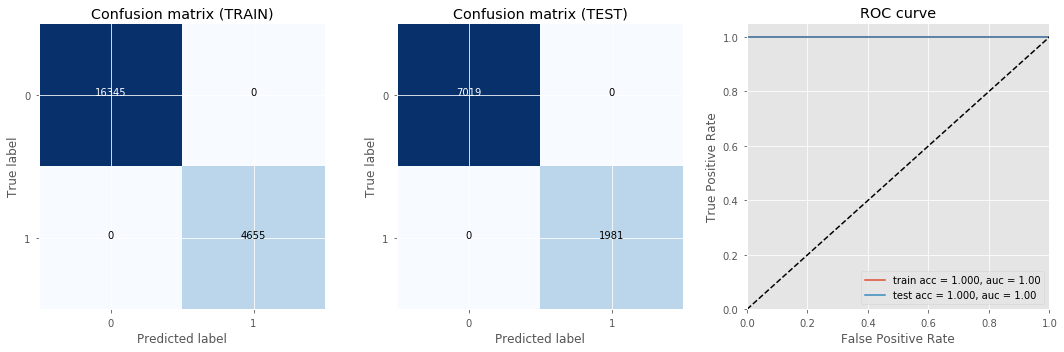

In [37]:

threshold = 0.5
y_train_pred = bst.predict(dtrain)
y_test_pred = bst.predict(dtest)

fig,ax = plt.subplots(1,3)
fig.set_size_inches(15,5)

plot_cm(ax[0],  y_train, y_train_pred, [0,1], 'Confusion matrix (TRAIN)', threshold)
plot_cm(ax[1],  y_test, y_test_pred,   [0,1], 'Confusion matrix (TEST)', threshold)
plot_auc(ax[2], y_train, y_train_pred, y_test, y_test_pred, threshold)
    
plt.tight_layout()
plt.show()

### 6.4) Feed forward deep neural nets

In [38]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

Using TensorFlow backend.


In [39]:
input_dim = X_train.shape[1]

model = Sequential()
model.add(Dense(256, input_shape=(input_dim,), activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(1,  activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


In [40]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [41]:
from keras.callbacks import Callback

class BatchLogger(Callback):
    def on_train_begin(self, epoch, logs={}):
        self.log_values = {}
        for k in self.params['metrics']:
            self.log_values[k] = []

    def on_epoch_end(self, batch, logs={}):
        for k in self.params['metrics']:
            if k in logs:
                self.log_values[k].append(logs[k])
    
    def get_values(self, metric_name, window):
        d =  pd.Series(self.log_values[metric_name])
        return d.rolling(window,center=False).mean()

bl = BatchLogger()

In [42]:
history = model.fit(
              np.array(X_train), np.array(y_train),
              batch_size=500, epochs=4, verbose=1, callbacks=[bl],
              validation_data=(np.array(X_test), np.array(y_test)))

Instructions for updating:
Use tf.cast instead.
Train on 21000 samples, validate on 9000 samples
Epoch 1/4
21000/21000 [==============================] - 94s 4ms/step - loss: 0.5734 - acc: 0.7497 - val_loss: 0.5464 - val_acc: 0.7799
Epoch 2/4
21000/21000 [==============================] - 95s 5ms/step - loss: 0.5440 - acc: 0.7783 - val_loss: 0.5390 - val_acc: 0.7799
Epoch 3/4
21000/21000 [==============================] - 81s 4ms/step - loss: 0.5379 - acc: 0.7783 - val_loss: 0.5341 - val_acc: 0.7799
Epoch 4/4
21000/21000 [==============================] - 82s 4ms/step - loss: 0.5341 - acc: 0.7783 - val_loss: 0.5309 - val_acc: 0.7799


In [43]:
score = model.evaluate(np.array(X_test), np.array(y_test), verbose=0)
print('Test log loss:', score[0])
print('Test accuracy:', score[1])

Test log loss: 0.5309452173974779
Test accuracy: 0.7798888888888889


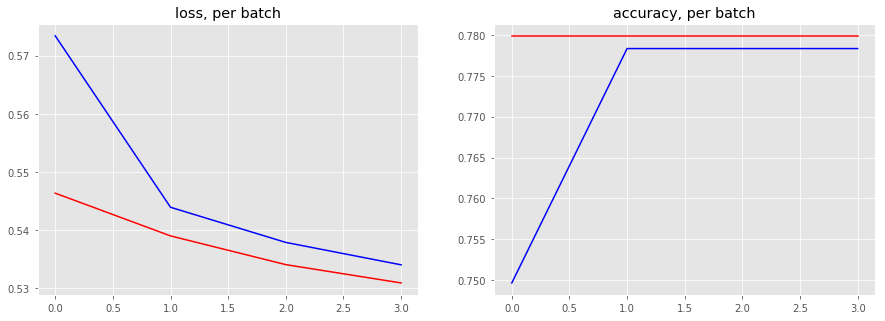

In [44]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.title('loss, per batch')
plt.plot(bl.get_values('loss',1), 'b-', label='train');
plt.plot(bl.get_values('val_loss',1), 'r-', label='test');

plt.subplot(1, 2, 2)
plt.title('accuracy, per batch')
plt.plot(bl.get_values('acc',1), 'b-', label='train');
plt.plot(bl.get_values('val_acc',1), 'r-', label='test');
plt.show()

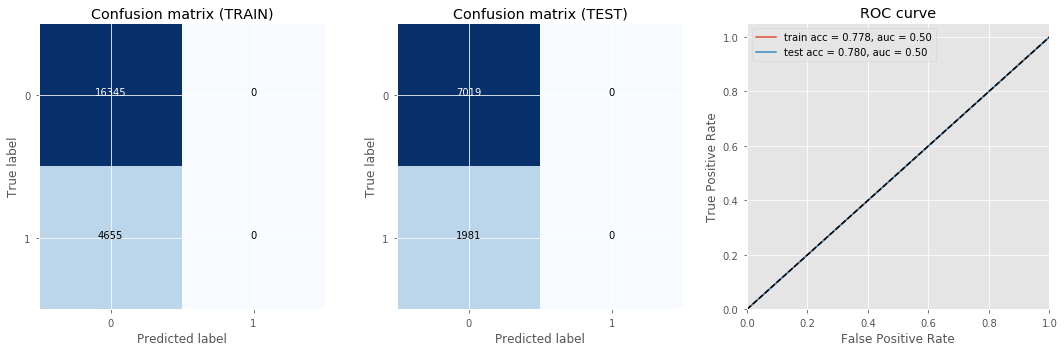

In [45]:
y_train_pred = model.predict_on_batch(np.array(X_train))[:,0]
y_test_pred = model.predict_on_batch(np.array(X_test))[:,0]

fig,ax = plt.subplots(1,3)
fig.set_size_inches(15,5)

plot_cm(ax[0], y_train, y_train_pred, [0,1], 'Confusion matrix (TRAIN)')
plot_cm(ax[1], y_test, y_test_pred, [0,1], 'Confusion matrix (TEST)')

plot_auc(ax[2], y_train, y_train_pred, y_test, y_test_pred)
    
plt.tight_layout()
plt.show()

In [56]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
# Data frame for evaluation metrics
metrics = pd.DataFrame(index=['accuracy', 'precision', 'recall'], 
                      columns=['LogisticReg', 'NaiveBayes'])

### 6.5) Naive Bayes Classifier

In [57]:
from sklearn.naive_bayes import GaussianNB
NBC = GaussianNB()
NBC.fit(X_train, y_train)

y_pred_test = NBC.predict(X_test)
metrics.loc['accuracy','NaiveBayes'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','NaiveBayes'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','NaiveBayes'] = recall_score(y_pred=y_pred_test, y_true=y_test)

In [58]:
print(100*metrics)

          LogisticReg NaiveBayes
accuracy          NaN    37.5556
precision         NaN    24.9069
recall            NaN    91.1661


### 6.6) Logistic Regression

In [59]:
from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression(n_jobs=-1, random_state=15)
logistic_regression.fit(X_train, y_train)

y_pred_test = logistic_regression.predict(X_test)
metrics.loc['accuracy','LogisticReg'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','LogisticReg'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','LogisticReg'] = recall_score(y_pred=y_pred_test, y_true=y_test)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [60]:
print(100*metrics)

          LogisticReg NaiveBayes
accuracy      77.9778    37.5556
precision           0    24.9069
recall              0    91.1661


In [61]:
y_pred_test = np.repeat(y_train.value_counts().idxmax(), y_test.size)
metrics.loc['accuracy','NULL'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','NULL'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','NULL'] = recall_score(y_pred=y_pred_test, y_true=y_test)

In [62]:
print(100*metrics)

          LogisticReg NaiveBayes       NULL
accuracy      77.9778    37.5556  77.988889
precision           0    24.9069   0.000000
recall              0    91.1661   0.000000


## 7. Model deployment and evaluation

In [102]:
# Using the logictic regression method for sample data input with a default probability > 20%
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
robust_scaler = RobustScaler()
X = df.drop(['target','age_cat'],axis=1)
X = robust_scaler.fit_transform(X)
y=df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

def make_ind_prediction(new_data):
    data = new_data.values.reshape(1, -1)
    data = robust_scaler.transform(data)
    prob = logistic_regression.predict_proba(data)[0][1]
    if prob >= 0.2:
        return 'Will default'
    else:
        return 'Will pay'

In [103]:
from collections import OrderedDict
new_customer = OrderedDict([('limit_bal', 4000),('age', 50 ),('bill_amt1', 500),
                            ('bill_amt2', 35509 ),('bill_amt3', 689 ),('bill_amt4', 0 ),
                            ('bill_amt5', 0 ),('bill_amt6', 0 ), ('pay_amt1', 0 ),('pay_amt2', 35509 ),
                            ('pay_amt3', 0 ),('pay_amt4', 0 ),('pay_amt5', 0 ), ('pay_amt6', 0 ),
                            ('male', 1 ),('grad_school', 0 ),('university', 1 ), ('married', 1 ),('pay_0', -1 ),('pay_2', -1 ),('pay_3', -1 ),
                            ('pay_4', 0),('pay_5', -1), ('pay_6', 0)])

new_customer = pd.Series(new_customer)
make_ind_prediction(new_customer)

'Will default'